# **Modelling and Evaluation Notebook**

## Objectives

* Fulfill Business Requirements 2 - predict if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherry_leaves_dataset/cherry_leaves/train
* inputs/cherry_leaves_dataset/cherry_leaves/validation
* inputs/cherry_leaves_dataset/cherry_leaves/test

## Outputs

* Image Augmentation.
* Image distribution plot, train vs validation vs test.
* Machine learning model creation and training.
* Plotting model performance.
* Prediction of a selected image file.



---

# Set Working Directory

In [ ]:
import os
current_dir = os.getcwd()
current_dir

In [ ]:
os.chdir("/workspace/cherry-leaves-mildew-detection")
print("You set a new current directory")

In [ ]:
current_dir = os.getcwd()
current_dir

### Set Input Directories

In [ ]:
data_dir = "inputs/cherry_leaves_dataset/cherry_leaves"
train_dir = data_dir + "/train"
val_dir = data_dir + "/validation"
test_dir = data_dir + "/test"

### Set Output Directory

In [ ]:
version = "v2"
file_path = f"outputs/{version}"
if "outputs" in os.listdir(current_dir) and version in os.listdir(current_dir + "/outputs"):
    print("This directory exists, create a new version.")
else:
    os.makedirs(name=file_path)

### Set Label Names

In [ ]:
labels = os.listdir(train_dir)
print("The image labels are", labels)

---

# Import Image Shape

In [ ]:
import joblib

image_shape = joblib.load(filename=f"outputs/v1/image_shape_embed.pkl")
image_shape

---

# Label Frequency Per Set

### Image Distribution Per Label Per Set

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

df_label_frequency = pd.DataFrame([])
for set in ["train", "validation", "test"]:
    for label in labels:
        count = int(len(os.listdir(data_dir + "/" + set + "/" + label)))
        df_label_frequency = df_label_frequency.append(pd.Series(data={"Dataset": set, 
                                                                       "Labels": label,
                                                                       "Frequency": count}),
                                                        ignore_index=True)

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_label_frequency, x="Dataset", y="Frequency", hue="Labels", palette="Accent")
plt.title("Label Distribution Per Set")
if "label_distribution_graph.jpg" not in file_path:
    plt.savefig(f"{file_path}/label_distribution_graph.jpg")
else:
    plt.show()

In [ ]:
colors = sns.color_palette("Accent")

df_label_set_frequency = []
for set in [train_dir, val_dir, test_dir]:
    for label in labels:
        count = int(len(os.listdir(set + "/" + label)))
        df_label_set_frequency.append(count)

set_label = ["train_healthy", "train_mildew", "val_healthy", "val_mildew", "test_healthy", "test_mildew"]

plt.pie(df_label_set_frequency, labels=set_label, colors=colors, autopct="%1.1f%%")
plt.title("Label Distribution Per Set")
if "label_distribution_pie_plot.jpg" not in file_path:
    plt.savefig(f"{file_path}/label_distribution_pie_plot.jpg")
else:
    plt.show()


The data is distrubted between the set in a 70:15:15 split. There are an equal number of healthy and powdery images so the dataset is balanced.

---

# Image Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialising ImageDataGenerator
augmented_images = ImageDataGenerator(rotation_range=25,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode="nearest",
                                      rescale=1./255
                                      )

### Augment Training Data

In [ ]:
# Set batch size the data will be looped over
batch_size = 20
# Augmented training data
train_set = augmented_images.flow_from_directory(train_dir,
                                                 target_size=image_shape[:2],
                                                 color_mode="rgb",
                                                 batch_size=batch_size,
                                                 class_mode="binary",
                                                 shuffle=True
                                                 )
train_set.class_indices

### Augment Validation Data

In [ ]:
# Set batch size the data will be looped over
batch_size = 20
# Augmented training data
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir,
                                                                 target_size=image_shape[:2],
                                                                 color_mode="rgb",
                                                                 batch_size=batch_size,
                                                                 class_mode="binary",
                                                                 shuffle=False
                                                                 )
val_set.class_indices

### Augment Test Data

In [ ]:
# Set batch size the data will be looped over
batch_size = 20
# Augmented training data
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                                  target_size=image_shape[:2],
                                                                  color_mode="rgb",
                                                                  batch_size=batch_size,
                                                                  class_mode="binary",
                                                                  shuffle=False
                                                                  )
test_set.class_indices

### Plot Augmented Images

In [ ]:
sets = {"Train": train_set, "Validation": val_set, "Test": test_set}
for name, set in sets.items():
    print(f"{name} Set")
    for _ in range(5):
        X, y = set.next()
        print(X.shape)
        plt.imshow(X[0])
        plt.show()

In [ ]:
# Save train set class indices
if "train_set_class_indices.pkl" not in file_path:
    joblib.dump(value=train_set.class_indices, filename=f"{file_path}/train_set_class_indices.pkl")

---

# Creating the Model

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D

n_labels = 2

def create_tf_model(input_shape, n_labels):
    """
    Function to define a sequential model which will
    arrange a sequence of layers in the neural network.
    Parameters are - input shape, which will be the image 
    shape and n_labels, where n is the number of labels.
    """
    model = Sequential()
    
    # Apply filters to the images to capture dominant patterns
    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=input_shape, activation="relu",))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=input_shape, activation="relu",))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=8, kernel_size=(3,3), input_shape=input_shape, activation="relu",))
    model.add(MaxPool2D(pool_size=(2, 2)))

    # Flatten the image matrix into a single list of all values
    model.add(Flatten())
    
    model.add(Dense(128, activation="relu"))
    # Add a dropout layer to reduce overfitting
    model.add(Dropout(0.3))

    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) 

    return model

In [ ]:
model = create_tf_model(input_shape=image_shape, n_labels=n_labels)
model.summary()

### Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=3)

### Fit Model

In [ ]:
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data = val_set,
          callbacks=early_stopping,
          verbose=1)

### Save Model

In [ ]:
if "mildew_detector.h5" not in {file_path}:
    model.save(f"{file_path}/mildew_detector.h5")

---

# Model Evaluation

In [ ]:
losses = pd.DataFrame(model.history.history)

sns.set_style("darkgrid")

losses[["loss", "val_loss"]].plot(style=".-")
plt.title("Loss")
if "model_loss.jpg" not in {file_path}:
    plt.savefig(f"{file_path}/model_loss.jpg")
plt.show()

losses[["accuracy", "val_accuracy"]].plot(style=".-")
plt.title("Accuracy")
if "model_accuracy.png" not in {file_path}:
    plt.savefig(f"{file_path}/model_accuracy.jpg")
plt.show()

### Load Saved Model

In [143]:
from keras.models import load_model
model = load_model(f"{file_path}/mildew_detector.h5")

In [145]:
# Evaluate model on test set
evaluate_test = model.evaluate(test_set)

32/32 [==============================] - 10s 321ms/step - loss: 0.0043 - accuracy: 0.9984


In [128]:
# Save evaluation
if "test_evaluation.pkl" not in file_path: 
    joblib.dump(value=evaluate_test, filename=f"{file_path}/test_evaluation.pkl")

### Predict on Unseen Data

Image Shape: (256, 256)
Image Mode: RGB


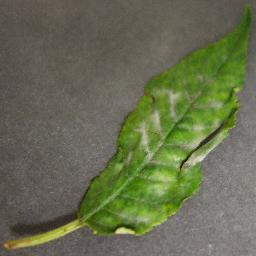

In [140]:
from tensorflow.keras.preprocessing import image

# Load a random image as pil
index = 300

label=labels[1]

pil_image = image.load_img(test_dir + "/" + label + "/" + os.listdir(test_dir + "/" + label)[index],
                           target_size=image_shape, color_mode="rgb")
print(f"Image Shape: {pil_image.size}\nImage Mode: {pil_image.mode}")
pil_image

In [141]:
# Convert image into array
test_image = image.img_to_array(pil_image)
test_image = np.expand_dims(test_image, axis=0)/255
print(test_image.shape)

(1, 256, 256, 3)


In [142]:
probability = model.predict(test_image)[0, 0]

class_indices = joblib.load(filename=f"{file_path}/train_set_class_indices.pkl")
# Reverse the key value pairs to map number to label
label_map = {value: key for key, value in class_indices.items()}
pred_class = label_map[probability > 0.5]

if pred_class == probability:
    probability = 1 - probability

print(f"The predicted probability value is {probability} so the predicted class is {pred_class}.")

The predicted probability value is 0.9999996423721313 so the predicted class is powdery_mildew.


---

# Conclusion

* The model has exceeded the business requirement of 97% prediction accuracy. The model can accurately predict whether an image can be classified as healthy or containing powdery mildew. 
* The Loss and Accuracy plots show the data hasn't overfitted, as the validation and training sets follow a similar path. Therefore the model can be used to predict unseen data. 